<a href="https://colab.research.google.com/github/stepsbtw/Machine-Learning/blob/main/AM_T1_CAIO_PASSOS_TORKST_FERREIRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Predição de pagamento de empréstimos (2 pts)

Uma instituição financeira (fictícia) possui uma base de dados com o histórico de crediário oferecido aos seus clientes. Baseado neste histórico, a instituição deseja investigar a criação de modelos de classificação para inferir se um novo cliente que submeteu uma requisição de empréstimo pagará ou não a dívida, caso o banco resolva realizar esse empréstimo. O objetivo é predizer se um novo cliente pagaria ou não uma dívida contraída, tendo como base as características desse novo cliente. Uma vez treinado, um modelo de classificação para esse problema poderá inferir se um novo cliente irá ou não honrar um eventual empréstimo concedido a ele.

O conjunto de dados a ser utilizado para treinamento possui 1500 exemplos, e contém dados relativos a créditos (empréstimos) concedidos aos clientes da instituição financeira. Esses registros estão contidos no arquivo credtrain.txt. É também fornecido um conjunto de exemplos de teste no arquivo credtest.txt. Para cada cliente, são definidos 11 atributos (variáveis preditoras). Além disso, a última coluna de cada arquivo informa se o cliente honrou ou não o pagamento do empréstimo. Na Tabela 1, encontramos a descrição dos atributos.

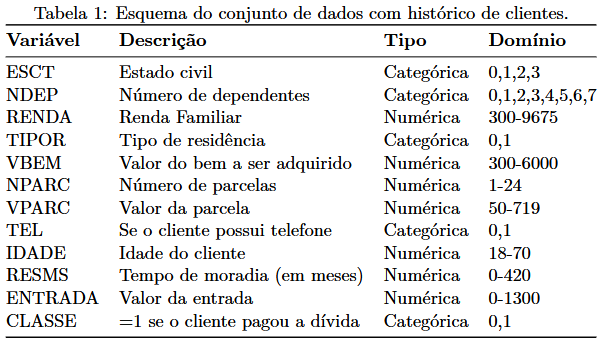

Antes de iniciar o treinamento, é preciso realizar diversos passos de pré-processamento sobre esses dados. Alguns aspectos que você deve levar em contar na sua solução:

- Esse conjunto de dados contém diversos atributos que são categóricos. Modelos de AM não podem ser treinados no Scikit-Learn sobre atributos cujos valores são cadeias de caracteres. Sendo assim, você deve tomar providências para codificar numericamente esses atributos de maneira apropriada.

- Dentre os atributos numéricos, há uma grande discrepância entre as suas respectivas faixas de valores. É sabido que diferenças grandes entre as faixas de valores dos atributos numéricos pode atrapalhar o processo de treinamento de alguns algoritmos de AM.

Após realizar os passos de pré-processamento adequados, você deve criar modelos de classificação por meio dos algoritmos de aprendizado de máquina implementados nas seguintes classes da biblioteca Scikit-Learn. (Por simplicidade, você pode manter os valores default dos hiperparâmetros de cada algoritmo.)

1. sklearn.linear_model.LogisticRegression
2. sklearn.neighbors.KNeighborsClassifier
3. sklearn.ensemble.GradientBoostingClassifier

Construa um gráfico que apresenta a curva ROC para os três algoritmos acima. Use algum dos critérios de escolha de limiar apresentado em aula para definir o limiar de classificação para cada um desses algoritmos.
Após o treinamento e a escolha de limiares adequados, você deve avaliar a qualidade preditiva dos modelos correspondentes. Para isso, você deve usar os exemplos do conjunto de teste.
Isso permitirá que você avalie o quão efetivo foi o passo de treinamento dos modelos, ou seja, qual o poder preditivo de cada modelo de classificação.

- Produza a matriz de confusão (confusion matrix) relativa aos resultados da fase de testes para cada modelo.
- Apresente também o relatório produzido pela função classification_report do Scikit-Learn.

In [267]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df_train = pd.read_csv("https://raw.githubusercontent.com/AILAB-CEFET-RJ/cic1205/refs/heads/main/data/credtrain.txt", sep="\t")
df_test = pd.read_csv("https://raw.githubusercontent.com/AILAB-CEFET-RJ/cic1205/refs/heads/main/data/credtest.txt", sep="\t")

colunas = ["ESCT","NDEP","RENDA","TIPOR","VBEM","NPARC","VPARC","TEL","IDADE","RESMS","ENTRADA","CLASSE"]
df_train.columns = colunas
df_test.columns = colunas

df_train.head(-5)

,ESCT,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE
0,0,0,350,1,468,10,65,0,33,6,0,1
1,0,0,1100,0,829,9,125,0,56,48,0,1
2,0,0,3000,0,552,12,76,1,31,60,0,1
3,1,0,1000,0,809,12,111,0,24,7,0,1
4,0,0,300,0,331,6,74,1,41,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1489,0,0,650,0,537,4,160,1,27,36,0,1
1490,0,0,543,0,502,12,68,0,33,48,0,1
1491,1,0,478,0,404,4,121,1,47,180,0,1
1492,0,0,541,1,408,5,100,0,31,6,0,0


**Os atributos categóricos já estão codificados! Mas precisamos tratar os numéricos, a faixa dos valores são muito discrepantes.**

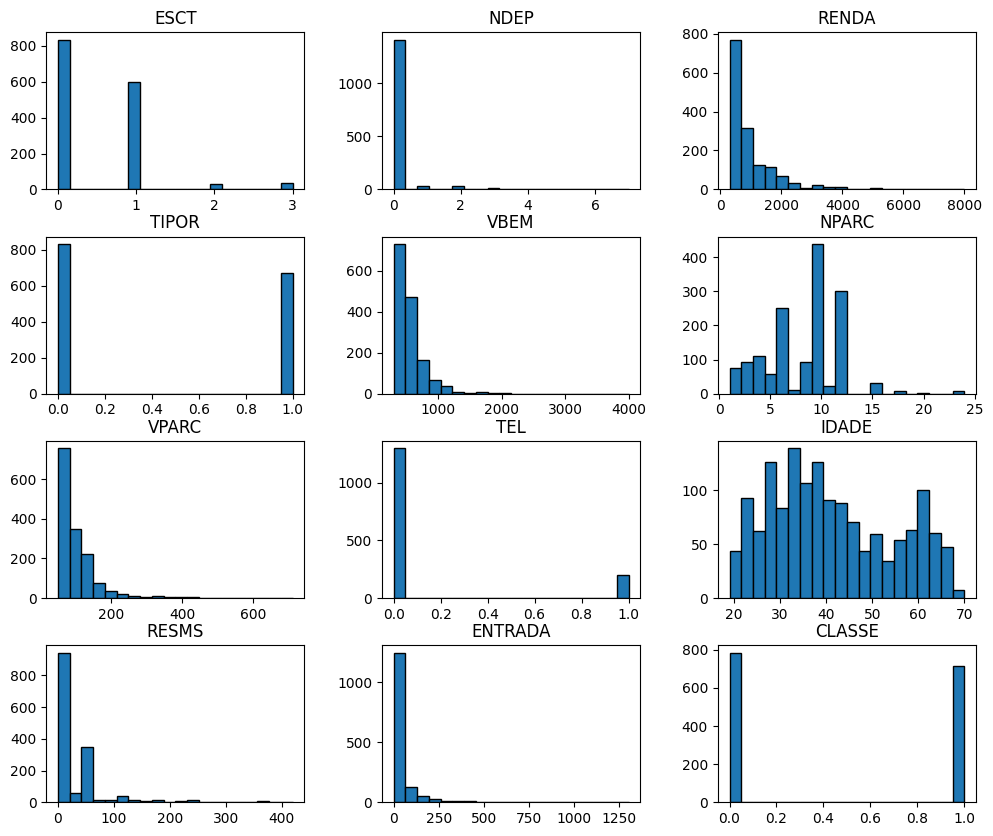

In [268]:
import matplotlib.pyplot as plt
df_train.hist(figsize=(12,10), edgecolor="black", grid=False, bins=20)
plt.show()

As features VPARC (Valor da Parcela), RENDA, VBEM (Valor do bem), RESMS (Tempo de Moradia) e ENTRADA estão **assimétricas à direita**, podem ser escaladas utilizando **Log Transform**.

As features IDADE e NPARC **parecem se aproximar de uma normal**, aplicaremos um **teste de normalidade**, se passar, podemos efetuar **Standardization**.



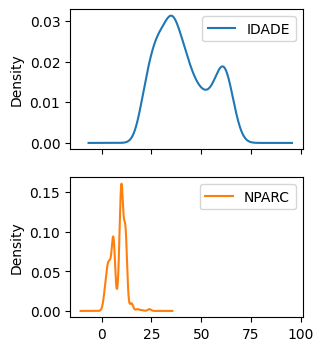

In [269]:
from seaborn import displot
# Testando os atributos "normais"
df_train_normaltest = df_train[["IDADE","NPARC"]].copy()
df_train_normaltest.plot(kind="kde",subplots=True,figsize=(3,4))
plt.show()

Nenhum teste mostrou normalidade, as features também não apresentam muitos outliers para aplicar RobustScaling. Portanto, utilizaremos o **MinMaxScaling**.

In [270]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df_train[["IDADE","NPARC"]])

def tratar_dados(data):
  # Tratando os atributos minmax
  df_minmax = data[["IDADE", "NPARC"]].copy()
  df_minmax[["IDADE", "NPARC"]] = scaler.transform(df_minmax[["IDADE", "NPARC"]])

  # Tratando os atributos "skewed"
  df_logT = data[["VPARC","RESMS","RENDA","ENTRADA","VBEM"]].copy()
  df_logT = np.log1p(df_logT)

  # Criando o df_scaled
  df_scaled = data.copy()
  df_scaled[["VPARC","RESMS","RENDA","ENTRADA","VBEM"]] = df_logT
  df_scaled[["IDADE", "NPARC"]] = df_minmax
  return df_scaled

df_train_scaled = tratar_dados(df_train)
df_test_scaled = tratar_dados(df_test)

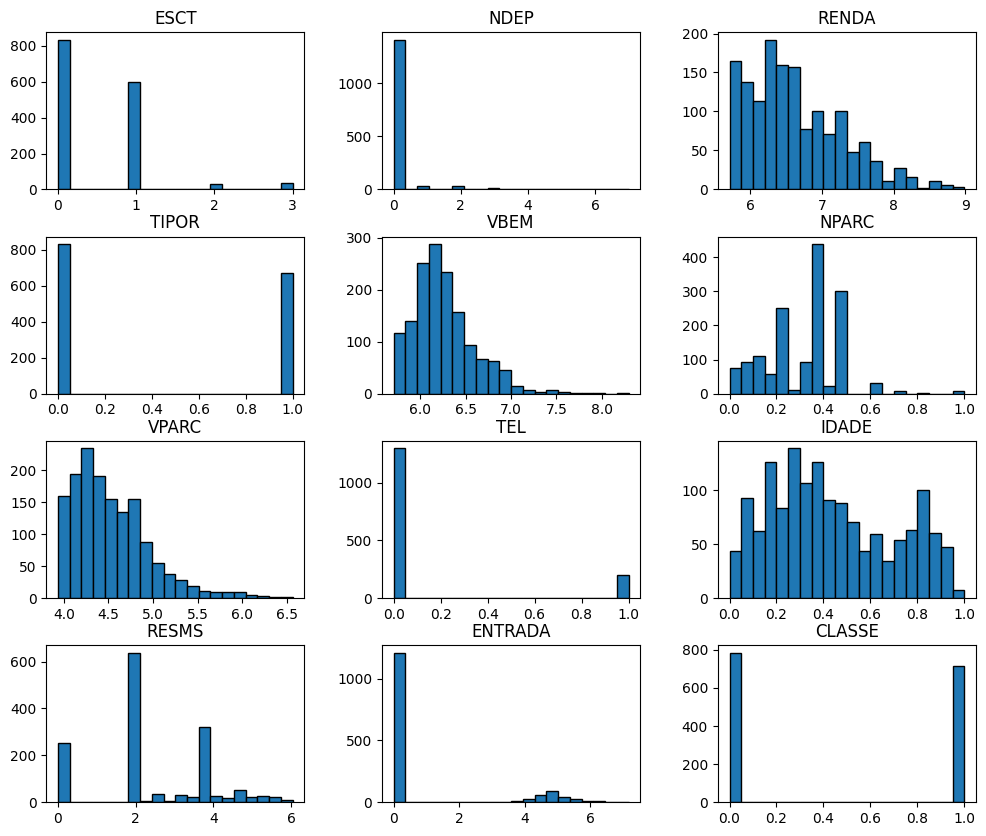

In [271]:
df_train_scaled.hist(figsize=(12,10), edgecolor="black", grid=False, bins=20)
plt.show()

OK! Todos os atributos escalados de maneira correta. Nosso dataset não parece ser desbalanceado.

In [272]:
print((df_train["CLASSE"] == 1).sum(), (df_train["CLASSE"] == 0).sum())
print((df_test["CLASSE"] == 1).sum(), (df_test["CLASSE"] == 0).sum())

714 785
271 305


In [273]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# instanciando modelos com hiperparâmetros default.
logreg = LogisticRegression()
knn = KNeighborsClassifier()
grad = GradientBoostingClassifier()

# realizando o three way holdout.
X_train = df_train_scaled.drop("CLASSE", axis=1)
y_train = df_train["CLASSE"]

X_test = df_test_scaled.drop("CLASSE", axis=1)
y_test = df_test_scaled["CLASSE"]

# treinando os modelos.
logreg.fit(X_train, y_train)
knn.fit(X_train, y_train)
grad.fit(X_train, y_train)

GradientBoostingClassifier()

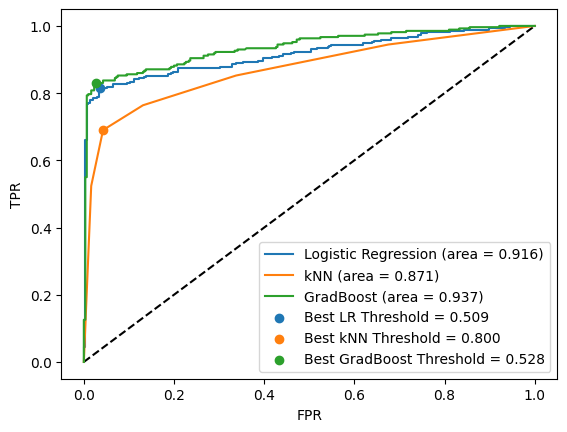

In [274]:
from sklearn.metrics import auc, roc_curve

# saídas de probabilidade
y_pred_prob_lr = logreg.predict_proba(X_test)[:,1]
y_pred_prob_knn = knn.predict_proba(X_test)[:,1]
y_pred_prob_grad = grad.predict_proba(X_test)[:,1] # [:,1] pegando a prob apenas da classe positiva.

# taxas de falsos e verdadeiros positivos + limiares pela curva ROC
FPR_lr, TPR_lr, thresholds_lr = roc_curve(y_test, y_pred_prob_lr)
FPR_knn, TPR_knn, thresholds_knn = roc_curve(y_test, y_pred_prob_knn)
FPR_grad, TPR_grad, thresholds_grad = roc_curve(y_test, y_pred_prob_grad)

# calculando a estatistica J e melhor threshold
J_lr = TPR_lr - FPR_lr
idx_lr = J_lr.argmax()
t_lr = thresholds_lr[idx_lr]
best_TPR_lr = TPR_lr[idx_lr]
best_FPR_lr = FPR_lr[idx_lr]

J_knn = TPR_knn - FPR_knn
idx_knn = J_knn.argmax()
t_knn = thresholds_knn[idx_knn]
best_TPR_knn = TPR_knn[idx_knn]
best_FPR_knn = FPR_knn[idx_knn]

J_grad = TPR_grad - FPR_grad
idx_grad = J_grad.argmax()
t_grad = thresholds_grad[idx_grad]
best_TPR_grad = TPR_grad[idx_grad]
best_FPR_grad = FPR_grad[idx_grad]

# calculando a area abaixo da curva
ROC_AUC_lr = auc(FPR_lr, TPR_lr)
ROC_AUC_knn = auc(FPR_knn, TPR_knn)
ROC_AUC_grad = auc(FPR_grad, TPR_grad)

# plotando as curvas roc para analise
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(FPR_lr, TPR_lr, label=f'Logistic Regression (area = {ROC_AUC_lr :.3f})')
plt.plot(FPR_knn, TPR_knn, label=f'kNN (area = {ROC_AUC_knn :.3f})')
plt.plot(FPR_grad, TPR_grad, label=f'GradBoost (area = {ROC_AUC_grad :.3f})')
plt.xlabel('FPR')
plt.ylabel('TPR')

# plotando os melhores limiares
plt.scatter(best_FPR_lr, best_TPR_lr, marker='o', label=f'Best LR Threshold = {t_lr:.3f}')
plt.scatter(best_FPR_knn, best_TPR_knn, marker='o', label=f'Best kNN Threshold = {t_knn:.3f}')
plt.scatter(best_FPR_grad, best_TPR_grad, marker='o', label=f'Best GradBoost Threshold = {t_grad:.3f}')


plt.legend(loc='best')
plt.show()

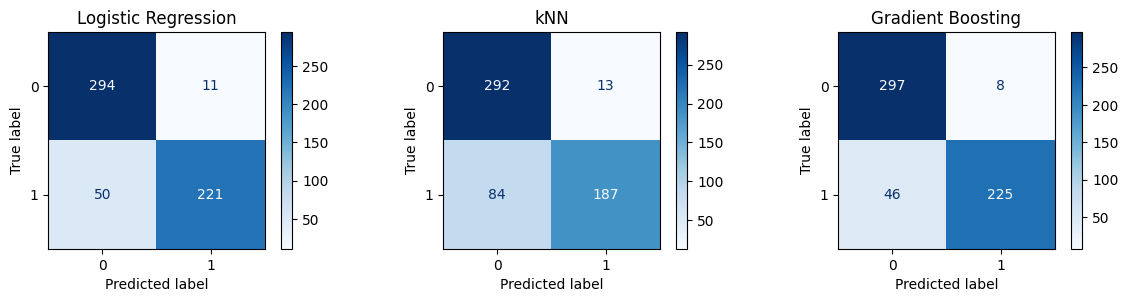

In [275]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# saídas de probabilidade para testes
'''
y_pred_prob_lr = logreg.predict_proba(X_test)[:,1]
y_pred_prob_knn = knn.predict_proba(X_test)[:,1]
y_pred_prob_grad = grad.predict_proba(X_test)[:,1] # [:,1] pegando a prob apenas da classe positiva.
'''

# usando os limiares para testar os modelos:
y_pred_lr = (y_pred_prob_lr >= t_lr).astype(int)
y_pred_knn = (y_pred_prob_knn >= t_knn).astype(int)
y_pred_grad = (y_pred_prob_grad >= t_grad).astype(int)

# gerando as matrizes de confusão:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_lr)).plot(ax=axes[0], cmap='Blues')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_knn)).plot(ax=axes[1], cmap='Blues')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_grad)).plot(ax=axes[2], cmap='Blues')

axes[0].set_title('Logistic Regression')
axes[1].set_title('kNN')
axes[2].set_title('Gradient Boosting')

# Ajustando o layout:
plt.tight_layout()
plt.show()

Analisando a área das curvas ROC, temos o quão bom no geral o modelo é em predizer a classe positiva! Comparando os modelos entre si, aparentemente o modelo com poder de predição maior é o Gradient Boost.

E apesar do dataset não ser desbalanceado, 0.777 parece ser um ótimo limiar para o Gradient Boost

In [276]:
from sklearn.metrics import classification_report

# avaliando os modelos:
lr_report = classification_report(y_test,y_pred_lr)
knn_report = classification_report(y_test,y_pred_knn)
grad_report = classification_report(y_test,y_pred_grad)

print(f"LogReg:\n {lr_report}\n")
print(f"kNN:\n {knn_report}\n")
print(f"gradBoost:\n {grad_report}\n")

LogReg:
               precision    recall  f1-score   support

           0       0.85      0.96      0.91       305
           1       0.95      0.82      0.88       271

    accuracy                           0.89       576
   macro avg       0.90      0.89      0.89       576
weighted avg       0.90      0.89      0.89       576


kNN:
               precision    recall  f1-score   support

           0       0.78      0.96      0.86       305
           1       0.94      0.69      0.79       271

    accuracy                           0.83       576
   macro avg       0.86      0.82      0.83       576
weighted avg       0.85      0.83      0.83       576


gradBoost:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       305
           1       0.97      0.83      0.89       271

    accuracy                           0.91       576
   macro avg       0.92      0.90      0.90       576
weighted avg       0.91      0.91      0.91  

## ANALISE AQUI

#(2) Predição de preços de diamantes
Nessa parte, você deve treinar um modelo de regressão sobre o conjunto de dados Diamond. Em particular, você deve criar um modelo para predizer o valor do preço (representado na variável dependente price) de um diamante usando os demais atributos como variáveis independentes. Repare que o conjunto de dados Diamond também contém variáveis não-numéricas. Sendo assim, você também precisará realizar passos de pré-processamento sobre o conjunto de dados
antes de iniciar o treinamento do modelo. Para isso, tome como exemplo os passos de pré-processamento realizados sobre o conjunto de dados de clientes.
Você deve criar modelos de predição (regressão) de preços por meio dos algoritmos de aprendizado de máquina implementados nas seguintes classes da biblioteca Scikit-Learn. (Por simplicidade, você pode manter os valores default dos hiperparâmetros de cada algoritmo. Lembre-se, entretanto)
1. sklearn.linear_model.LinearRegression
2. sklearn.neighbors.KNeighborsRegressor
3. sklearn.ensemble.GradientBoostingRegressor
Após o treinamento, você deve avaliar a qualidade preditiva de cada modelo de classificação resultante. Para isso, você deve previamente separar aleatoriamente 20% dos exemplos fornecidos para formarem o conjunto de teste. Isso permitirá que você obtenha uma estimativa do quão efetivos são os modelos gerados. Certifique-se de avaliar todos os modelos sobre o mesmo conjunto de teste.

1. Reporte o poder preditivo dos modelos que você construiu. Como métricas de avaliação, use o RMSE e o coeficiente e determinação R2.
2. Apresente uma análise dos resultados obtidos. Como parte dessa análise, para cada um dos modelos gerados, construa gráficos conforme os exemplificados neste [link](https://github.com/AILAB-CEFET-RJ/cic1205/blob/main/notebooks/model_evaluation_regression.ipynb).

In [301]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/AILAB-CEFET-RJ/cic1205/refs/heads/main/data/diamonds.csv")
print(df.info())
df.head()
# price é o nosso target e é variavel dependente das outras. alguma combinacao linear!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB
None


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [302]:
X_df = df.drop(columns=["price"])
y_df = df["price"]
X_df.describe()

,carat,depth,table,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,10.740000,58.900000,31.800000


Checar os atributos categóricos:

In [303]:
print(X_df["cut"].unique())
print(X_df["color"].unique())
print(X_df["clarity"].unique())

['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
['E' 'I' 'J' 'H' 'F' 'G' 'D']
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


Vou precisar tratar as variáveis categóricas! (Feature Encoding).

A "cut" diz sobre a qualidade do corte, a "clarity" uma medida sobre quão claro é o diamante, a "color" quão boa é a cor do diamante.

Todas possuem hierárquia entre os possíveis valores, então seria ideal utilizar Ordinal Encoding.

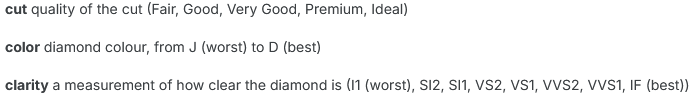

In [304]:
cut_mapping = {"Ideal":1, "Premium":2, "Very Good":3, "Good":4, "Fair":5}
color_mapping = {"D":1, "E":2, "F":3, "G":4, "H":5, "I":6, "J":7}
clarity_mapping = {"IF":1, "VVS1":2, "VVS2":3, "VS1":4, "VS2":5, "SI1":6, "SI2":7, "I1":8}

X_df["cut_encoded"] = X_df["cut"].map(cut_mapping)
X_df["color_encoded"] = X_df["color"].map(color_mapping)
X_df["clarity_encoded"] = X_df["clarity"].map(clarity_mapping)

In [305]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X_df, test_size=0.2)

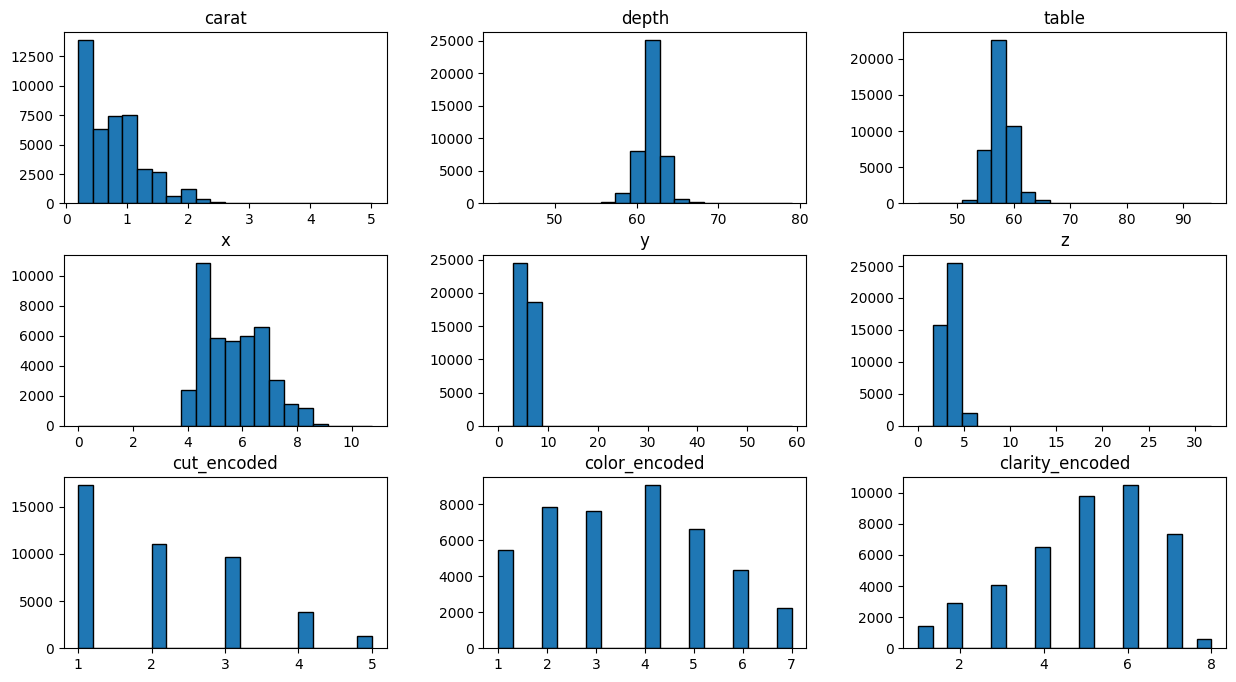

In [306]:
import matplotlib.pyplot as plt
X_train.hist(figsize=(15,8), edgecolor="black", grid=False, bins=20)
plt.show()

Tratar valores numéricos! (Feature Scaling), vou testar a normalidade:

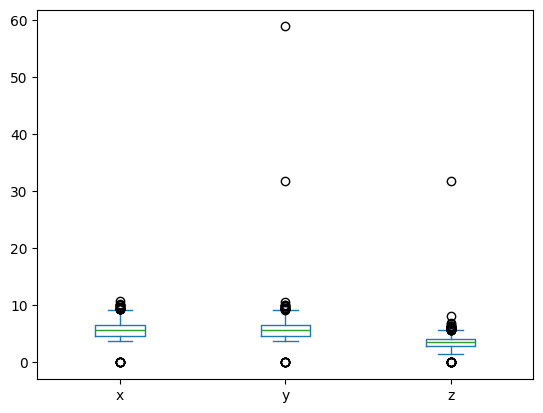

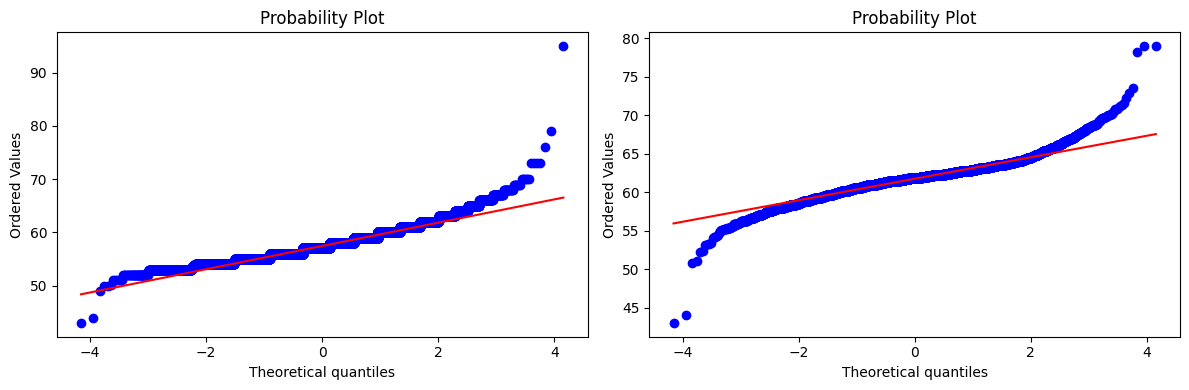

In [307]:
X_train[["x","y","z"]].plot(kind="box") # checar outliers

import scipy.stats as stats

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
stats.probplot(X_train["table"], dist="norm", plot=plt)
plt.subplot(1,2,2)
stats.probplot(X_train["depth"], dist="norm", plot=plt)

plt.tight_layout()
plt.show()

Enfim, nenhum atributo parece seguir uma normal.
- carat precisa ser Log Transformed
- x,y,z,table,depth precisam ser Robust Scaled

In [308]:
import numpy as np
from sklearn.preprocessing import RobustScaler

# log transform
X_train["carat_scaled"] = np.log1p(X_train["carat"])
X_test["carat_scaled"] = np.log1p(X_test["carat"])

X_train["y_scaled"] = np.log1p(X_train["y"])
X_test["y_scaled"] = np.log1p(X_test["y"])

X_train["z_scaled"] = np.log1p(X_train["z"])
X_test["z_scaled"] = np.log1p(X_test["z"])

# robust scaling
scaler = RobustScaler()
scaler.fit(X_train[["x", "table", "depth"]])

X_train_scaled = scaler.transform(X_train[["x", "table", "depth"]])
X_test_scaled = scaler.transform(X_test[["x", "table", "depth"]])

# adicionar novas colunas
X_train[["x_scaled", "table_scaled", "depth_scaled"]] = X_train_scaled
X_test[["x_scaled", "table_scaled", "depth_scaled"]] = X_test_scaled

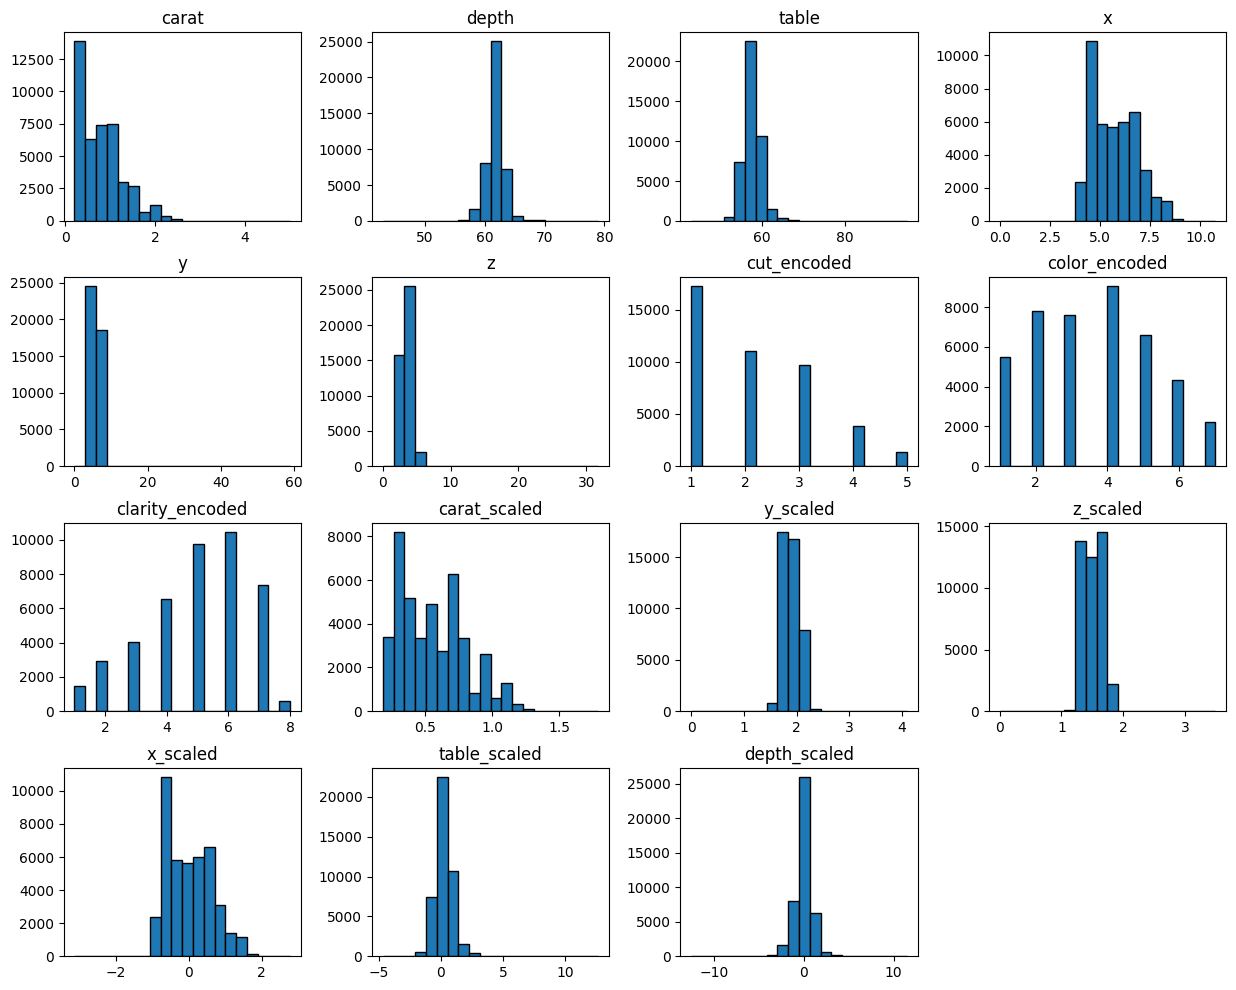

In [309]:
import matplotlib.pyplot as plt
X_train.hist(figsize=(15,12), edgecolor="black", grid=False, bins=20)
plt.show()

In [310]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

logreg = LinearRegression()
knn = KNeighborsRegressor()
grad = GradientBoostingRegressor()